<a href="https://colab.research.google.com/github/adrian-ai-salud/adrian-ai-salud/blob/main/Estudio%20UNIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del estudio UNIR IA

# Análisis de fiabilidad del cuestionario

In [1]:
!pip install pingouin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.3 MB/s eta 0:00:00


In [2]:
# Paso 1: Subir el archivo CSV manualmente
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import pingouin as pg

# Leer archivo (el primero subido)
filename = next(iter(uploaded))
df = pd.read_csv(filename)

# Paso 2: Seleccionar solo las columnas tipo Likert (preguntas 1 a 10)
cols_likert = [col for col in df.columns if col.strip().startswith(tuple([f"{i}." for i in range(1, 11)]))]
df_likert = df[cols_likert].copy()

# Paso 3: Limpieza de respuestas (espacios, mayúsculas, errores ortográficos)
def limpiar(texto):
    texto = str(texto).strip().lower()
    if "moi en desacordo" in texto or "totalemnte en desacordo" in texto or "totalmente en desacordo" in texto:
        return "moi en desacordo"
    elif "en desacordo" in texto:
        return "en desacordo"
    elif "nin de acordo" in texto:
        return "nin de acordo nin en desacordo"
    elif "de acordo" in texto and "totalmente" not in texto:
        return "de acordo"
    elif "totalmente de acordo" in texto:
        return "totalmente de acordo"
    else:
        return np.nan

df_likert = df_likert.applymap(limpiar)

# Paso 4: Convertir a escala numérica (1-5)
likert_map = {
    "moi en desacordo": 1,
    "en desacordo": 2,
    "nin de acordo nin en desacordo": 3,
    "de acordo": 4,
    "totalmente de acordo": 5
}
df_likert = df_likert.replace(likert_map)

# Paso 5: Separar constructos
constructo1_cols = [cols_likert[i] for i in [0,1,2,3,4,6]]  # ítems 1,2,3,4,5,7
constructo2_cols = [cols_likert[i] for i in [5,7,8,9]]      # ítems 6,8,9,10

constructo1 = df_likert[constructo1_cols].dropna()
constructo2 = df_likert[constructo2_cols].dropna()

# Paso 6: Calcular alfa de Cronbach
alpha1 = pg.cronbach_alpha(constructo1)[0]
alpha2 = pg.cronbach_alpha(constructo2)[0]

# Resultados
print(f"✅ Alfa de Cronbach Constructo 1: {round(alpha1, 3)} — n = {constructo1.shape[0]}")
print(f"✅ Alfa de Cronbach Constructo 2: {round(alpha2, 3)} — n = {constructo2.shape[0]}")


Saving Estudio UNIR.csv to Estudio UNIR.csv
✅ Alfa de Cronbach Constructo 1: 0.79 — n = 102
✅ Alfa de Cronbach Constructo 2: 0.328 — n = 102


<ipython-input-2-668814493>:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_likert = df_likert.applymap(limpiar)
<ipython-input-2-668814493>:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_likert = df_likert.replace(likert_map)


In [3]:
import pandas as pd
import numpy as np
from scipy import stats

def resumen_descriptivo_con_ic(data, alpha=0.05):
    resumen = pd.DataFrame(columns=["Media", "Desviación típica", "IC 95% (Límite inferior)", "IC 95% (Límite superior)"])

    for col in data.columns:
        x = data[col].dropna()
        media = x.mean()
        std = x.std(ddof=1)
        n = len(x)
        se = std / np.sqrt(n)
        t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
        ci_lower = media - t_crit * se
        ci_upper = media + t_crit * se

        resumen.loc[col.strip()] = [round(media, 2), round(std, 2), round(ci_lower, 2), round(ci_upper, 2)]

    # Añadir resumen total del constructo (media por fila)
    x_total = data.mean(axis=1).dropna()
    media_total = x_total.mean()
    std_total = x_total.std(ddof=1)
    n_total = len(x_total)
    se_total = std_total / np.sqrt(n_total)
    t_total = stats.t.ppf(1 - alpha/2, df=n_total - 1)
    ci_lower_total = media_total - t_total * se_total
    ci_upper_total = media_total + t_total * se_total

    resumen.loc["MEDIA CONSTRUCTO"] = [round(media_total, 2), round(std_total, 2), round(ci_lower_total, 2), round(ci_upper_total, 2)]

    return resumen

# ----------------------------
# Cálculo por constructo
# ----------------------------
resumen_c1 = resumen_descriptivo_con_ic(constructo1)
resumen_c2 = resumen_descriptivo_con_ic(constructo2)

# ----------------------------
# Añadir media_constructo1 y media_constructo2 si existen
# ----------------------------
extra_constructos = []
if "media_constructo1" in df.columns and "media_constructo2" in df.columns:
    extra_constructos = df[["media_constructo1", "media_constructo2"]]
    resumen_extras = resumen_descriptivo_con_ic(extra_constructos)
else:
    resumen_extras = None

# ----------------------------
# Mostrar resultados
# ----------------------------
print("📊 Resumen descriptivo detallado – Constructo 1")
display(resumen_c1)
print(f"ℹ️ N total de casos válidos constructo 1: {constructo1.shape[0]}")

print("\n📊 Resumen descriptivo detallado – Constructo 2")
display(resumen_c2)
print(f"ℹ️ N total de casos válidos constructo 2: {constructo2.shape[0]}")

if resumen_extras is not None:
    print("\n📊 Resumen adicional – Media de cada constructo (columnas directas del DataFrame)")
    display(resumen_extras)


📊 Resumen descriptivo detallado – Constructo 1


,Media,Desviación típica,IC 95% (Límite inferior),IC 95% (Límite superior)
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.,3.90,1.01,3.70,4.10
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas,3.92,0.96,3.73,4.11
3.Creo que a IA pode mellorar os indicadores de saúde da poboación,3.84,1.06,3.63,4.05
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro,3.73,1.14,3.50,3.95
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo,3.28,1.22,3.04,3.52
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA,2.29,0.99,2.10,2.49
MEDIA CONSTRUCTO,3.50,0.75,3.35,3.64


ℹ️ N total de casos válidos constructo 1: 102

📊 Resumen descriptivo detallado – Constructo 2


,Media,Desviación típica,IC 95% (Límite inferior),IC 95% (Límite superior)
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario,4.16,0.85,3.99,4.32
8.Creo que recibín unha formación adecuada para usar IA no meu traballo,1.69,0.96,1.50,1.88
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo,2.47,1.22,2.23,2.71
"10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario",3.22,1.29,2.96,3.47
MEDIA CONSTRUCTO,2.88,0.63,2.76,3.01


ℹ️ N total de casos válidos constructo 2: 102


In [12]:
from pingouin import cronbach_alpha

def evaluar_alfa_tras_eliminar(data, nombre_constructo):
    print(f"\n🔍 Evaluación del alfa de Cronbach eliminando cada ítem en {nombre_constructo}:\n")
    for col in data.columns:
        subset = data.drop(columns=[col])
        alpha = cronbach_alpha(subset)[0]
        print(f"🗑️ Sin '{col.strip()}': alfa = {round(alpha, 3)}")

# Análisis por constructo
evaluar_alfa_tras_eliminar(constructo1, "Constructo 1")
evaluar_alfa_tras_eliminar(constructo2, "Constructo 2")



🔍 Evaluación del alfa de Cronbach eliminando cada ítem en Constructo 1:

🗑️ Sin '1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.': alfa = 0.758
🗑️ Sin '2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas': alfa = 0.734
🗑️ Sin '3.Creo que a IA pode mellorar os indicadores de saúde da poboación': alfa = 0.708
🗑️ Sin '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro': alfa = 0.754
🗑️ Sin '5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo': alfa = 0.765
🗑️ Sin '7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA': alfa = 0.817

🔍 Evaluación del alfa de Cronbach eliminando cada ítem en Constructo 2:

🗑️ Sin '6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario': alfa = 0.165
🗑️ Sin '8.Creo que recibín unha formación adecuada para usar IA no meu trabal

In [13]:
# Comprobamos los valores únicos después de limpiar
for col in df_likert.columns:
    print(f"{col}: {df_likert[col].unique()}")


1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.  : [5 4 2]
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas   : [5 4 2]
3.Creo que a IA pode mellorar os indicadores de saúde da poboación  : [5 4 2]
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  : [5 4 2]
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo   : [5 2 4 1]
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario    : [5 4 2]
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA      : [4 2 1 5]
8.Creo que recibín unha formación adecuada para usar IA no meu traballo        : [1 2 5 4]
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo        : [4 2 1 5]
10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae n

In [14]:
df_likert.count()


,0
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.,102
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas,102
3.Creo que a IA pode mellorar os indicadores de saúde da poboación,102
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro,102
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo,102
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario,102
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA,102
8.Creo que recibín unha formación adecuada para usar IA no meu traballo,102
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo,102
"10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario",102


In [15]:
print("Constructo 1:", list(constructo1_cols))
print("Constructo 2:", list(constructo2_cols))

print("\nFilas válidas constructo 1:", len(constructo1))
print("Filas válidas constructo 2:", len(constructo2))


Constructo 1: ['1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.  ', '2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas   ', '3.Creo que a IA pode mellorar os indicadores de saúde da poboación  ', '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  ', '5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo   ', '7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA      ']
Constructo 2: ['6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario    ', '8.Creo que recibín unha formación adecuada para usar IA no meu traballo        ', '9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo        ', '10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario  ']

Fi

In [16]:
for col in df_likert.columns:
    print(f"\n📋 {col.strip()}")
    print(df_likert[col].value_counts(dropna=False).sort_index())



📋 1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.  
2    19
4    55
5    28
Name: count, dtype: int64

📋 2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas   
2    17
4    59
5    26
Name: count, dtype: int64

📋 3.Creo que a IA pode mellorar os indicadores de saúde da poboación
3.Creo que a IA pode mellorar os indicadores de saúde da poboación  
2    22
4    52
5    28
Name: count, dtype: int64

📋 4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  
2    28
4    46
5    28
Name: count, dtype: int64

📋 5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo
5.Creo que a introdución da IA pode red

# Análisis factorial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=96650cbb26560fe49650e2daca08de9bc4d29fb72f4659c0428e2915eac8bacc
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer
✅ Test de esfericidad de Bartlett: χ² = 310.225, p = 0.00000
✅ Índice KMO global: 0.784


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


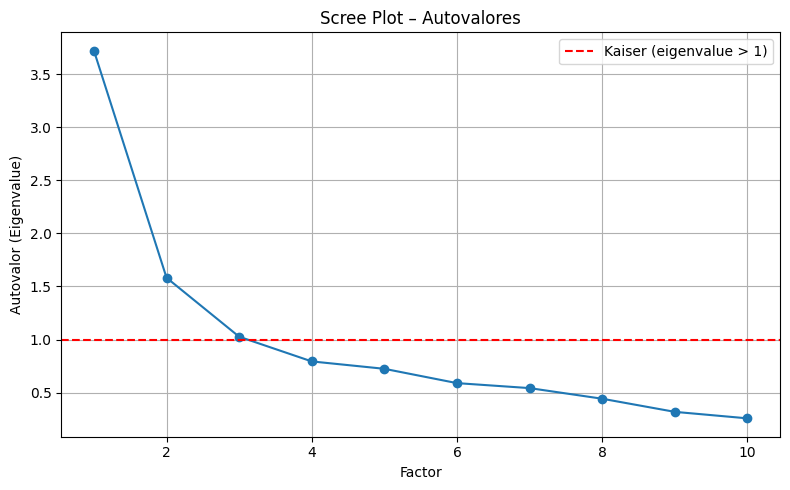


🔍 Cargas factoriales:
                                                    Factor 1  Factor 2
1.Creo que o uso da IA na miña especialidade po...      0.62      0.16
2. Creo que o uso da IA na miña especialidade p...      0.78      0.06
3.Creo que a IA pode mellorar os indicadores de...      0.81      0.10
4.Creo que a IA pode cambiar o meu papel como p...      0.67     -0.01
5.Creo que a introdución da IA pode reducir o c...      0.59      0.12
6.Creo que algún día a IA poderá formar parte d...      0.69      0.14
7.Creo que a maioría dos profesionais sanitario...      0.22      0.49
8.Creo que recibín unha formación adecuada para...      0.14      0.72
9.Creo que existe un marco ético para o uso da ...      0.15      0.57
10.Creo que, se a tecnoloxía baseada en IA come...      0.06     -0.21

📈 Comunalidades:
                                                    Comunalidad
1.Creo que o uso da IA na miña especialidade po...         0.40
2. Creo que o uso da IA na miña especialidade p...

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
# 1. Instalar librería si no la tienes
!pip install factor_analyzer

# 2. Importar librerías necesarias
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Preparar los datos (df_likert debe estar creado y limpio)
df_af = df_likert.copy().dropna()

# 4. Pruebas previas: Bartlett y KMO
chi_square_value, p_value = calculate_bartlett_sphericity(df_af)
print(f"✅ Test de esfericidad de Bartlett: χ² = {chi_square_value:.3f}, p = {p_value:.5f}")

kmo_all, kmo_model = calculate_kmo(df_af)
print(f"✅ Índice KMO global: {kmo_model:.3f}")

# 5. Scree plot (determinación del número óptimo de factores)
fa = FactorAnalyzer(rotation=None)
fa.fit(df_af)

ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title("Scree Plot – Autovalores")
plt.xlabel("Factor")
plt.ylabel("Autovalor (Eigenvalue)")
plt.grid(True)
plt.axhline(1, color='red', linestyle='--', label='Kaiser (eigenvalue > 1)')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Análisis factorial con rotación Varimax (puedes ajustar n_factors según el scree plot)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df_af)

# 7. Cargas factoriales
cargas = pd.DataFrame(fa.loadings_, index=df_af.columns, columns=['Factor 1', 'Factor 2'])
print("\n🔍 Cargas factoriales:")
print(cargas.round(2))

# 8. Comunalidades
comunalidades = pd.DataFrame(fa.get_communalities(), index=df_af.columns, columns=["Comunalidad"])
print("\n📈 Comunalidades:")
print(comunalidades.round(2))

# 9. Varianza explicada
varianza = pd.DataFrame(fa.get_factor_variance(),
                        index=["Varianza", "Proporción", "Proporción acumulada"],
                        columns=[f"Factor {i+1}" for i in range(fa.n_factors)])
print("\n📊 Varianza explicada:")
print(varianza.round(2))


In [ ]:
df[['media_constructo1', 'media_constructo2']].corr(method='spearman')


,media_constructo1,media_constructo2
media_constructo1,1.000000,0.362885
media_constructo2,0.362885,1.000000


# Valoración del cuestionario

Análisis factorial exploratorio de los ítems tipo Likert
Para explorar la estructura subyacente del cuestionario utilizado en este estudio, se realizó un análisis factorial exploratorio (AFE) sobre los 10 ítems tipo Likert que valoran la percepción de los profesionales de enfermería sobre la inteligencia artificial (IA) en su práctica clínica.

Antes de realizar el análisis, se evaluó la adecuación de los datos mediante el test de esfericidad de Bartlett y el índice de Kaiser-Meyer-Olkin (KMO). El test de Bartlett fue estadísticamente significativo (χ² = 310.225, p < 0.001), lo que indica que las correlaciones entre los ítems son suficientemente fuertes para justificar el análisis factorial. El índice KMO global fue de 0.784, lo que refleja una adecuación del muestreo buena.

La determinación del número óptimo de factores se basó en el gráfico de sedimentación (scree plot), donde se observó un claro “codo” tras el segundo factor. Además, solo los dos primeros factores presentaron autovalores mayores a 1, cumpliendo con el criterio de Kaiser. Por tanto, se extrajeron dos factores y se aplicó rotación Varimax para facilitar la interpretación.

Las cargas factoriales mostraron una estructura clara. Los ítems 1 a 6 presentaron cargas elevadas en el primer factor (valores entre 0.59 y 0.81), mientras que los ítems 8 y 9 cargaron en el segundo factor con valores superiores a 0.5. El ítem 7 presentó una carga moderada en el segundo factor (0.49), mientras que el ítem 10 no mostró cargas significativas en ninguno de los dos factores, sugiriendo que no se ajusta adecuadamente a la estructura latente del cuestionario. En consecuencia, podría considerarse su eliminación o reformulación en futuras aplicaciones del instrumento.

En cuanto a las comunalidades, siete de los diez ítems presentaron valores superiores a 0.4, lo que indica que una proporción aceptable de su varianza es explicada por los factores extraídos. El ítem 10 mostró una comunalidad muy baja (0.05), reforzando la evidencia de su escasa aportación al modelo factorial.

La varianza total explicada por el modelo de dos factores fue del 42%, distribuyéndose en un 30% para el primer factor y un 12% para el segundo. Estos valores son aceptables dentro del ámbito de las ciencias sociales.

En conjunto, los resultados respaldan la existencia de dos dimensiones diferenciadas en la percepción de la IA por parte de los profesionales de enfermería. El primer factor puede interpretarse como la valoración general positiva sobre el impacto de la IA en la práctica clínica, mientras que el segundo factor refleja aspectos relacionados con la preparación profesional, formación y marco ético necesario para su implementación. Estos hallazgos aportan solidez psicométrica a la estructura del cuestionario y ofrecen una base empírica para su uso en futuras investigaciones.

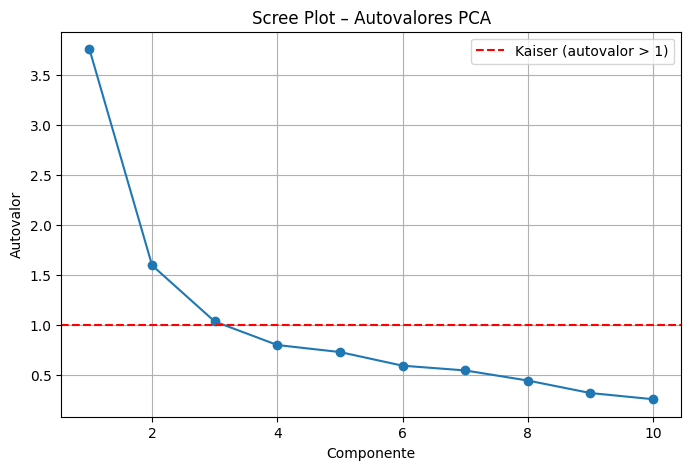

,Autovalor,Proporción,Acumulada
0,3.757,0.372,0.372
1,1.598,0.158,0.530
2,1.037,0.103,0.633
3,0.802,0.079,0.712
4,0.732,0.072,0.785
5,0.596,0.059,0.844
6,0.548,0.054,0.898
7,0.447,0.044,0.942
8,0.322,0.032,0.974
9,0.261,0.026,1.000


📊 Cargas PCA (sin rotación):


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.,0.36,-0.04,-0.35,0.51,-0.09,0.09,0.25,0.01,0.63,-0.07
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas,0.41,-0.17,-0.19,0.13,-0.22,0.23,-0.14,-0.41,-0.51,-0.45
3.Creo que a IA pode mellorar os indicadores de saúde da poboación,0.42,-0.13,-0.06,-0.15,0.25,0.30,-0.24,-0.23,0.01,0.72
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro,0.35,-0.23,0.05,-0.48,0.16,-0.40,-0.36,0.02,0.38,-0.36
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo,0.35,-0.10,0.22,-0.40,-0.12,0.00,0.80,0.02,-0.08,0.02
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario,0.39,-0.12,0.11,0.28,-0.19,-0.25,-0.15,0.70,-0.32,0.17
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA,0.22,0.45,-0.09,0.12,0.78,-0.04,0.14,0.11,-0.21,-0.20
8.Creo que recibín unha formación adecuada para usar IA no meu traballo,0.20,0.54,0.19,0.13,-0.28,-0.55,-0.04,-0.44,-0.00,0.20
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo,0.19,0.50,0.39,-0.14,-0.23,0.57,-0.21,0.21,0.21,-0.18
"10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario",-0.01,-0.35,0.76,0.42,0.26,0.02,0.01,-0.21,0.08,-0.07


✅ Test de esfericidad de Bartlett: χ² = 310.23, p = 0.00000
✅ KMO global: 0.784

📌 Cargas factoriales (rotación oblimin):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Factor 1,Factor 2
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.,0.62,0.09
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas,0.80,-0.03
3.Creo que a IA pode mellorar os indicadores de saúde da poboación,0.82,-0.03
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro,0.69,-0.08
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo,0.57,0.07
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario,0.66,0.09
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA,0.14,0.45
8.Creo que recibín unha formación adecuada para usar IA no meu traballo,-0.03,0.78
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo,0.03,0.58
"10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario",0.09,-0.20



📌 Comunalidades:


,Comunalidad
1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.,0.39
2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas,0.64
3.Creo que a IA pode mellorar os indicadores de saúde da poboación,0.68
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro,0.48
5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo,0.33
6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario,0.44
7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA,0.23
8.Creo que recibín unha formación adecuada para usar IA no meu traballo,0.60
9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo,0.33
"10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario",0.05



📌 Varianza explicada por factores:


,Factor 1,Factor 2
Varianza,2.948,1.213
Proporción,0.295,0.121
Acumulada,0.295,0.416


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

# -------------------------------
# 1. Preparar los datos
# -------------------------------
# Asegúrate de que df_likert tenga solo columnas 1 a 10 del cuestionario (numéricas de 1 a 5)
df_pca = df_likert.dropna().copy()
items = df_pca.columns

# -------------------------------
# 2. PCA exploratorio
# -------------------------------
# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Ajustar PCA
pca = PCA()
pca.fit(df_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser (autovalor > 1)')
plt.title("Scree Plot – Autovalores PCA")
plt.xlabel("Componente")
plt.ylabel("Autovalor")
plt.legend()
plt.grid(True)
plt.show()

# Tabla de varianza explicada
var_exp = pd.DataFrame({
    "Autovalor": pca.explained_variance_,
    "Proporción": pca.explained_variance_ratio_,
    "Acumulada": pca.explained_variance_ratio_.cumsum()
})
display(var_exp.round(3))

# Cargas principales
cargas_pca = pd.DataFrame(pca.components_.T, index=items, columns=[f"CP{i+1}" for i in range(len(items))])
print("📊 Cargas PCA (sin rotación):")
display(cargas_pca.round(2))

# -------------------------------
# 3. Análisis factorial con rotación oblicua
# -------------------------------
# Test de adecuación
bartlett_test = calculate_bartlett_sphericity(df_pca)
kmo_test = calculate_kmo(df_pca)

print(f"✅ Test de esfericidad de Bartlett: χ² = {bartlett_test[0]:.2f}, p = {bartlett_test[1]:.5f}")
print(f"✅ KMO global: {kmo_test[1]:.3f}")

# Ajustar FA con rotación oblicua (oblimin) y extracción máxima verosimilitud
fa = FactorAnalyzer(n_factors=2, rotation='oblimin', method='ml')
fa.fit(df_pca)

# Cargas factoriales
cargas_fa = pd.DataFrame(fa.loadings_, index=items, columns=['Factor 1', 'Factor 2'])
comunalidades = pd.DataFrame(fa.get_communalities(), index=items, columns=['Comunalidad'])

# Varianza explicada
varianza_fa = pd.DataFrame(fa.get_factor_variance(), index=['Varianza', 'Proporción', 'Acumulada'], columns=['Factor 1', 'Factor 2'])

print("\n📌 Cargas factoriales (rotación oblimin):")
display(cargas_fa.round(2))

print("\n📌 Comunalidades:")
display(comunalidades.round(2))

print("\n📌 Varianza explicada por factores:")
display(varianza_fa.round(3))


Análisis factorial exploratorio de los ítems tipo Likert

Para explorar la estructura subyacente del cuestionario utilizado en este estudio, se realizó un análisis factorial exploratorio (AFE) sobre los 10 ítems tipo Likert que valoran la percepción de los profesionales de enfermería sobre la inteligencia artificial (IA) en su práctica clínica.

Antes de realizar el análisis, se evaluó la adecuación de los datos mediante el test de esfericidad de Bartlett y el índice de Kaiser-Meyer-Olkin (KMO). El test de Bartlett fue estadísticamente significativo (χ² = 310.225, p < 0.001), lo que indica que las correlaciones entre los ítems son suficientemente fuertes para justificar el análisis factorial. El índice KMO global fue de 0.784, lo que refleja una adecuación del muestreo buena.

La determinación del número óptimo de factores se basó en el gráfico de sedimentación (scree plot), donde se observó un claro “codo” tras el segundo factor. Además, solo los dos primeros factores presentaron autovalores mayores a 1 (3.757 y 1.598), explicando conjuntamente el 53.0 % de la varianza total. Sin embargo, el análisis factorial posterior con rotación oblimin (más adecuada cuando se presume correlación entre los factores) mostró una varianza total explicada del 41.6 %, con un 29.5 % correspondiente al primer factor y un 12.1 % al segundo.

Las cargas factoriales mostraron una estructura clara y coherente. Los ítems 1 a 6 presentaron cargas elevadas en el primer factor (entre 0.57 y 0.82), lo que sugiere una dimensión relacionada con la actitud favorable hacia la IA en la práctica clínica. Por su parte, los ítems 8 y 9 cargaron fuertemente en el segundo factor (valores > 0.5), que puede interpretarse como una dimensión asociada a la formación profesional y aspectos éticos. El ítem 7 mostró una carga moderada (0.45) en el segundo factor, vinculado a la percepción de preparación del colectivo profesional. El ítem 10, sin embargo, no mostró cargas significativas en ninguno de los dos factores (máxima carga -0.20), lo que sugiere que no se ajusta adecuadamente a la estructura latente del cuestionario. En consecuencia, podría considerarse su eliminación o reformulación en futuras aplicaciones del instrumento.

En cuanto a las comunalidades, siete de los diez ítems presentaron valores superiores a 0.4, lo que indica que una proporción aceptable de su varianza es explicada por los factores extraídos. Nuevamente, el ítem 10 presentó una comunalidad muy baja (0.05), reforzando la evidencia de su escasa aportación al modelo factorial.

Además del AFE, se realizó un análisis de componentes principales (PCA) con estandarización de los datos. Este mostró que los tres primeros componentes presentaban autovalores superiores a 1 (criterio de Kaiser), y explicaban en conjunto un 63.3 % de la varianza. No obstante, el patrón de cargas fue más difuso, y el análisis factorial oblicuo mostró una estructura más interpretable y teóricamente coherente, lo que refuerza su idoneidad para este estudio.

En conjunto, los resultados respaldan la existencia de dos dimensiones diferenciadas en la percepción de la IA por parte de los profesionales de enfermería gallegos de atención primaria. El primer factor puede interpretarse como la valoración general positiva sobre el impacto de la IA en la práctica clínica, mientras que el segundo factor refleja aspectos relacionados con la preparación, la formación y el marco ético necesario para su implementación. Estos hallazgos aportan solidez psicométrica a la estructura del cuestionario y ofrecen una base empírica para su uso en futuras investigaciones.

# Análisis descriptivo de las variables

📊 Estadísticos descriptivos de edad:
- N válidos: 101
- Media: 41.56
- Desviación típica: 11.83
- Mediana: 39.00
- Mínimo: 24.0 — Máximo: 67.0
- IQR (rango intercuartílico): 21.00
- IC 95% de la media: [39.23, 43.90]
- Asimetría: 0.29
- Curtosis: -1.18


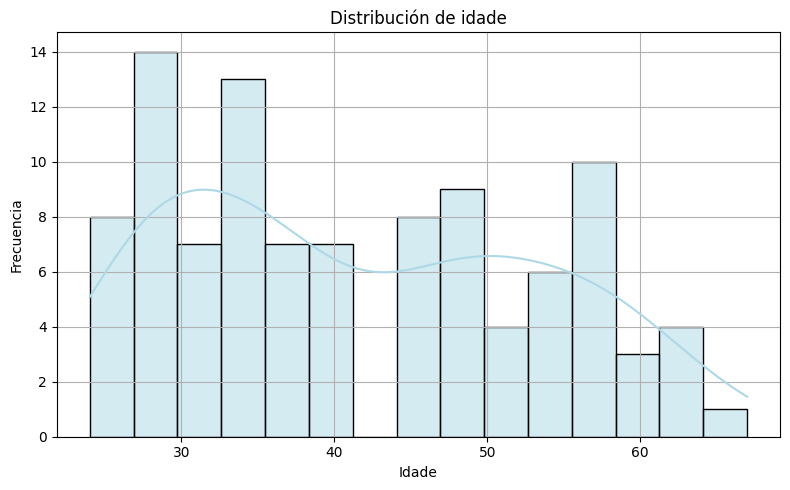

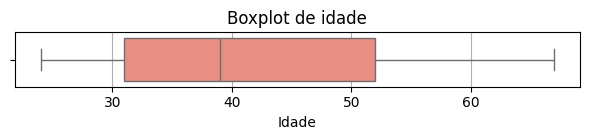

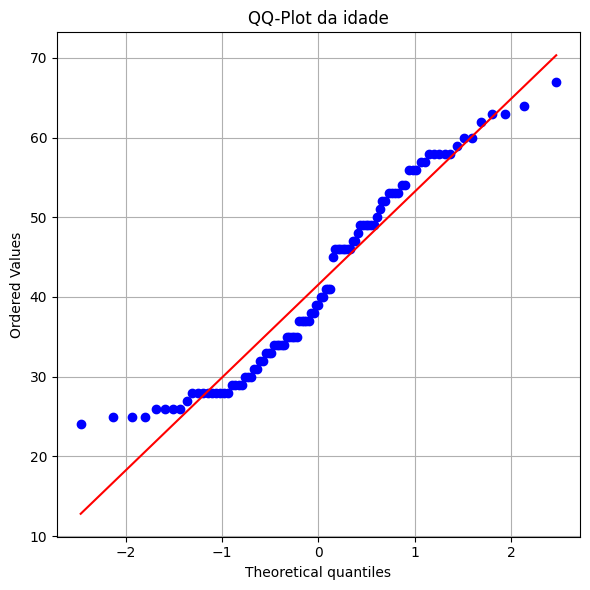


🔍 Shapiro-Wilk: W = 0.937, p = 0.00011
❌ A distribución da idade NON é normal.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display

# 🔧 Asegurarse de que 'Idade' está limpia y numérica
df.rename(columns=lambda x: x.strip(), inplace=True)
df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
edad = df['Idade'].dropna()

# ✅ Estadísticos básicos + IC 95%
media = edad.mean()
std = edad.std(ddof=1)
n = len(edad)
se = std / np.sqrt(n)
t_crit = stats.t.ppf(1 - 0.05/2, df=n-1)
ci_inf = media - t_crit * se
ci_sup = media + t_crit * se
mediana = edad.median()
iqr = np.percentile(edad, 75) - np.percentile(edad, 25)
minimo = edad.min()
maximo = edad.max()
asimetria = stats.skew(edad)
curtosis = stats.kurtosis(edad)

print("📊 Estadísticos descriptivos de edad:")
print(f"- N válidos: {n}")
print(f"- Media: {media:.2f}")
print(f"- Desviación típica: {std:.2f}")
print(f"- Mediana: {mediana:.2f}")
print(f"- Mínimo: {minimo} — Máximo: {maximo}")
print(f"- IQR (rango intercuartílico): {iqr:.2f}")
print(f"- IC 95% de la media: [{ci_inf:.2f}, {ci_sup:.2f}]")
print(f"- Asimetría: {asimetria:.2f}")
print(f"- Curtosis: {curtosis:.2f}")

# 📈 Histograma + KDE
plt.figure(figsize=(8,5))
sns.histplot(edad, kde=True, bins=15, color='lightblue')
plt.title("Distribución de idade")
plt.xlabel("Idade")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Boxplot
plt.figure(figsize=(6,1.5))
sns.boxplot(x=edad, color='salmon')
plt.title("Boxplot de idade")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# 📏 QQ-plot
plt.figure(figsize=(6,6))
stats.probplot(edad, dist="norm", plot=plt)
plt.title("QQ-Plot da idade")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Test de normalidad: Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(edad)
print(f"\n🔍 Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.5f}")
if shapiro_p > 0.05:
    print("✅ A distribución da idade pode considerarse normal.")
else:
    print("❌ A distribución da idade NON é normal.")


# Análisis de supuestos pruebas paramétricos

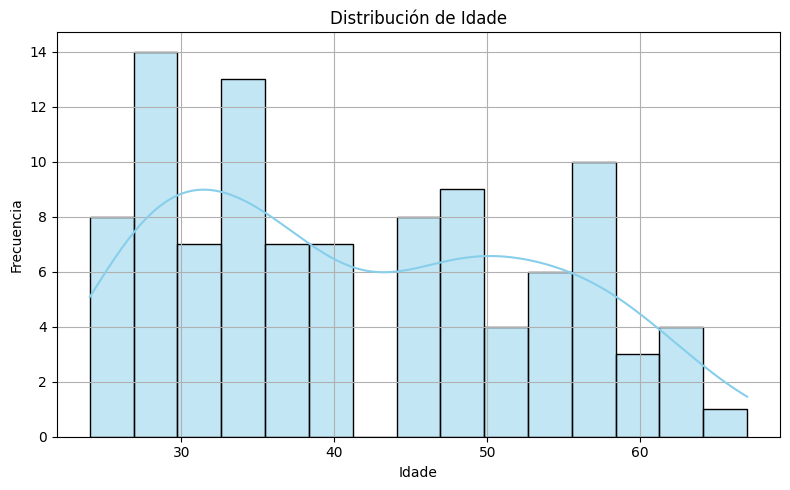

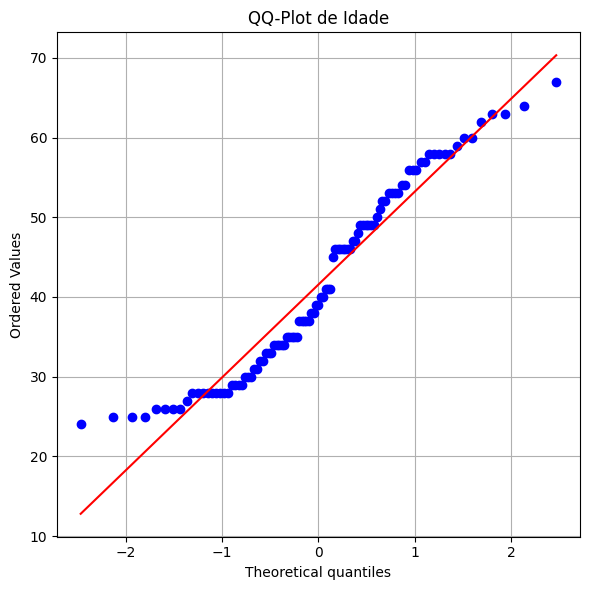

🔍 Shapiro-Wilk: W = 0.937, p = 0.00011
📏 Kolmogorov-Smirnov: D = 0.126, p = 0.07268


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 🔧 Nos aseguramos que la columna esté limpia
df.rename(columns=lambda x: x.strip(), inplace=True)
df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
edad = df['Idade'].dropna()

# 📊 HISTOGRAMA + KERNEL DENSITY
plt.figure(figsize=(8,5))
sns.histplot(edad, kde=True, bins=15, color='skyblue')
plt.title("Distribución de Idade")
plt.xlabel("Idade")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 QQ-PLOT (probabilidad acumulada vs normal)
plt.figure(figsize=(6,6))
stats.probplot(edad, dist="norm", plot=plt)
plt.title("QQ-Plot de Idade")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ TEST DE NORMALIDAD: Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(edad)
print(f"🔍 Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.5f}")

# ✅ TEST DE NORMALIDAD: Kolmogorov-Smirnov (opcional)
ks_stat, ks_p = stats.kstest(edad, 'norm', args=(edad.mean(), edad.std()))
print(f"📏 Kolmogorov-Smirnov: D = {ks_stat:.3f}, p = {ks_p:.5f}")


# Análisi de la normalidad de los constructos

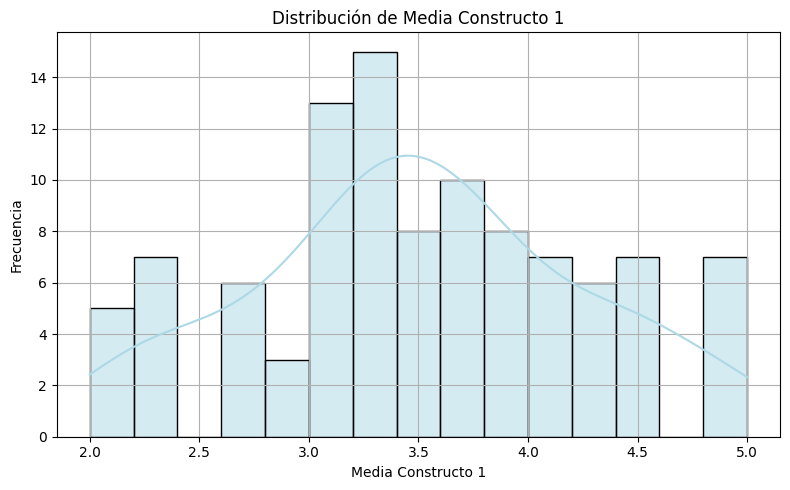

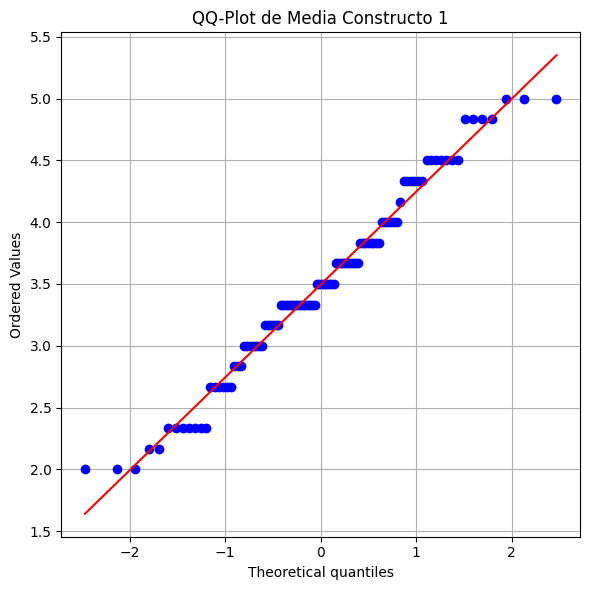

🔍 Shapiro-Wilk para Media Constructo 1: W = 0.977, p = 0.06687
✅ Media Constructo 1 parece seguir una distribución normal.



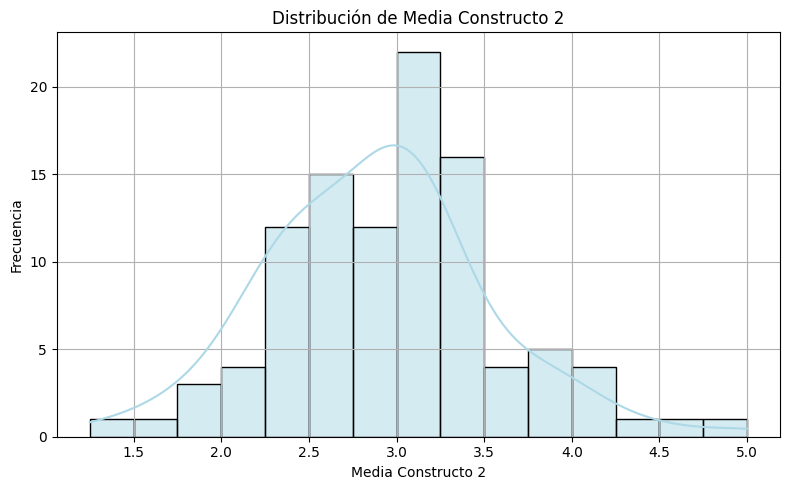

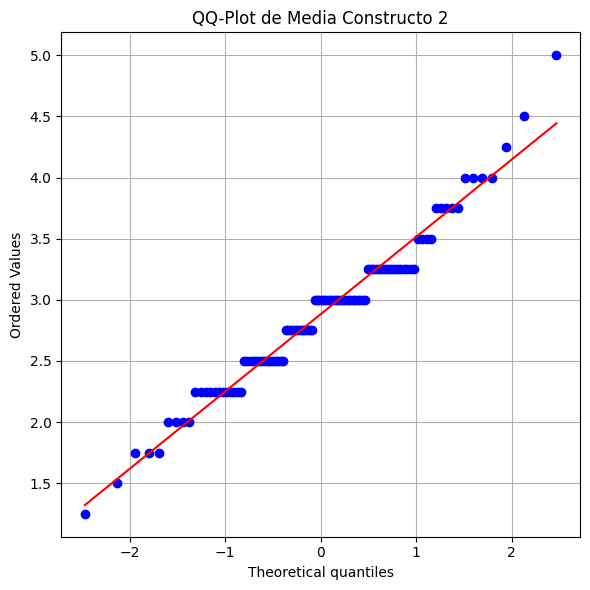

🔍 Shapiro-Wilk para Media Constructo 2: W = 0.972, p = 0.03156
❌ Media Constructo 2 **no** sigue una distribución normal.



In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 Asegurar que columnas estén limpias
df_likert.columns = df_likert.columns.str.strip()

# 🧱 Definir columnas por constructo
constructo1_cols = ['1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.',
                    '2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas',
                    '3.Creo que a IA pode mellorar os indicadores de saúde da poboación',
                    '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro',
                    '5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo',
                    '7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA']

constructo2_cols = ['6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario',
                    '8.Creo que recibín unha formación adecuada para usar IA no meu traballo',
                    '9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo',
                    '10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario']

# 🧮 Calcular puntuación media por persona
df['media_constructo1'] = df_likert[constructo1_cols].mean(axis=1)
df['media_constructo2'] = df_likert[constructo2_cols].mean(axis=1)

# 🔍 Función de análisis de normalidad
def analizar_normalidad(serie, nombre='Variable'):
    x = serie.dropna()

    # Histograma con KDE
    plt.figure(figsize=(8,5))
    sns.histplot(x, kde=True, bins=15, color='lightblue')
    plt.title(f"Distribución de {nombre}")
    plt.xlabel(nombre)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # QQ-plot
    plt.figure(figsize=(6,6))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"QQ-Plot de {nombre}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    stat, p = stats.shapiro(x)
    print(f"🔍 Shapiro-Wilk para {nombre}: W = {stat:.3f}, p = {p:.5f}")
    if p > 0.05:
        print(f"✅ {nombre} parece seguir una distribución normal.\n")
    else:
        print(f"❌ {nombre} **no** sigue una distribución normal.\n")

# 📈 Ejecutar análisis para los dos constructos
analizar_normalidad(df['media_constructo1'], "Media Constructo 1")
analizar_normalidad(df['media_constructo2'], "Media Constructo 2")



📋 Análisis univariante de: Sexo


,Frecuencia,Porcentaje (%)
Sexo,,
Muller,84,82.35
Home,18,17.65


📌 Total válidos: 102
📌 Total nulos: 0
📌 Moda: Muller


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


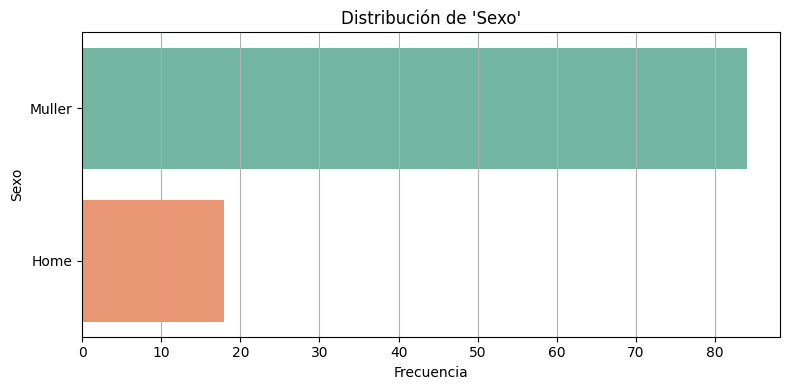


📋 Análisis univariante de: Anos de experiencia profesional en enfermaría


,Frecuencia,Porcentaje (%)
Anos de experiencia profesional en enfermaría,,
>10 anos,64,62.75
6-10 anos,20,19.61
1-5 anos,18,17.65


📌 Total válidos: 102
📌 Total nulos: 0
📌 Moda: >10 anos


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


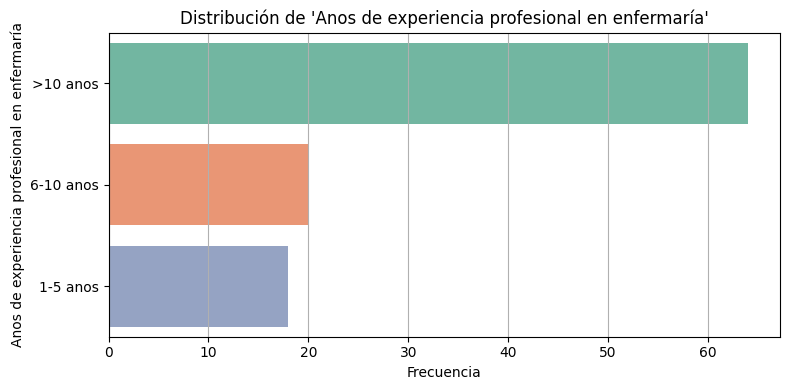


📋 Análisis univariante de: Nivel educativo


,Frecuencia,Porcentaje (%)
Nivel educativo,,
Grado,68,66.67
Máster,32,31.37
Doutorado,2,1.96


📌 Total válidos: 102
📌 Total nulos: 0
📌 Moda: Grado


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


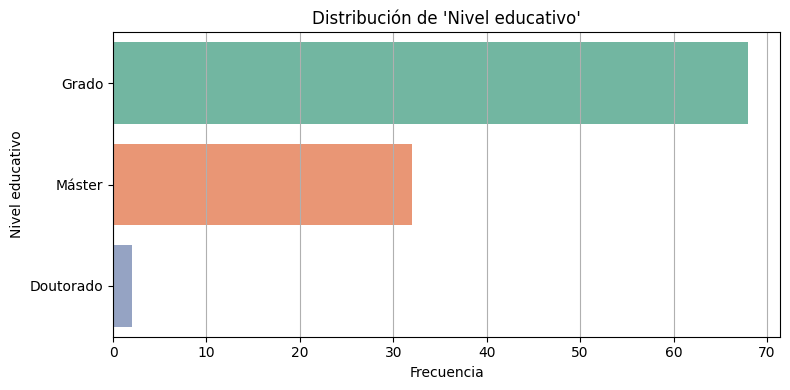


📋 Análisis univariante de: Área Sanitaria na que traballa


,Frecuencia,Porcentaje (%)
Área Sanitaria na que traballa,,
Santiago-Barbanza,81,79.41
Ourense-Verín-O Barco,6,5.88
Vigo,5,4.90
A Coruña-Cee,3,2.94
Pontevedra-Salnés,3,2.94
Lugo-A Mariña-Monforte,2,1.96
Ferrol,2,1.96


📌 Total válidos: 102
📌 Total nulos: 0
📌 Moda: Santiago-Barbanza


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


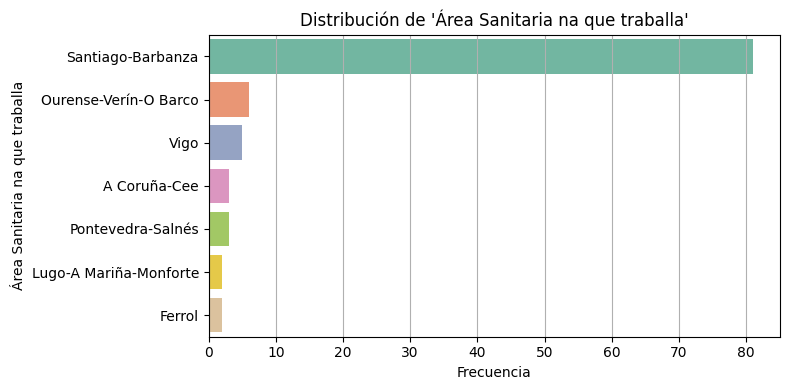


📋 Análisis univariante de: Ámbito de traballo


,Frecuencia,Porcentaje (%)
Ámbito de traballo,,
Urbano,51,50.0
Rural,51,50.0


📌 Total válidos: 102
📌 Total nulos: 0
📌 Moda: Rural


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


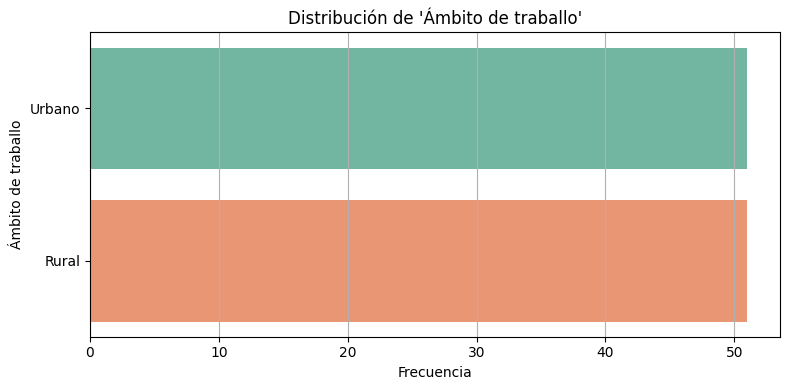

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 🔧 Limpiar nombres
df.rename(columns=lambda x: x.strip(), inplace=True)

# 🧾 Lista de variables categóricas
variables_categoricas = [
    'Sexo',
    'Anos de experiencia profesional en enfermaría',
    'Nivel educativo',
    'Área Sanitaria na que traballa',
    'Ámbito de traballo'
]

# 📊 Función de análisis categórico profundo
def analizar_variable_categorica(df, var):
    print(f"\n📋 Análisis univariante de: {var}")
    serie = df[var].dropna()

    # Tabla de frecuencias
    tabla = serie.value_counts().to_frame(name="Frecuencia")
    tabla["Porcentaje (%)"] = round((tabla["Frecuencia"] / len(serie)) * 100, 2)

    # Estadísticos
    n_validos = serie.count()
    n_nulos = df[var].isnull().sum()
    moda = serie.mode().values[0] if not serie.mode().empty else "—"

    # Imprimir tabla
    display(tabla)
    print(f"📌 Total válidos: {n_validos}")
    print(f"📌 Total nulos: {n_nulos}")
    print(f"📌 Moda: {moda}")

    # Gráfico
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')
    plt.title(f"Distribución de '{var}'")
    plt.xlabel("Frecuencia")
    plt.ylabel(var)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# ▶️ Ejecutar para cada variable categórica
for var in variables_categoricas:
    analizar_variable_categorica(df, var)


# Valores perdido

In [23]:
df.isnull().sum().sort_values(ascending=False)


,0
Idade,1
grupo_idade,1
grupo_idade_3cat,1
Sexo,0
"Despois de ler a información sobre o estudo, acepta participar de forma voluntaria?",0
Marca temporal,0
Área Sanitaria na que traballa,0
Ámbito de traballo,0
"Con que frecuencia usa tecnoloxía dixital na súa práctica clínica fora dos programas corporativos? ""A tecnoloxía dixital inclúe calquera ferramenta electrónica ou software que empregue na súa práctica clínica, como historias clínicas electrónicas, aplicacións de xestión de pacientes, plataformas de teleconsulta, sistemas de prescrición electrónica, dispositivos de monitorización dixital ou ferramentas de apoio á toma de decisións clínicas baseadas en datos"".",0
En que medida comprende o concepto de Intelixencia Artificial (IA)?,0


# Revisión de outliers


📌 Variable: Idade
- IQR: 21.00
- Límites: [-32.00, 115.00]
- N outliers severos: 0
✅ Sin outliers severos detectados.


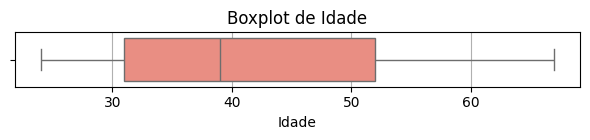


📌 Variable: media_constructo1
- IQR: 1.00
- Límites: [0.00, 7.00]
- N outliers severos: 0
✅ Sin outliers severos detectados.


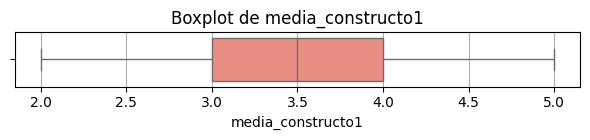


📌 Variable: media_constructo2
- IQR: 0.75
- Límites: [0.25, 5.50]
- N outliers severos: 0
✅ Sin outliers severos detectados.


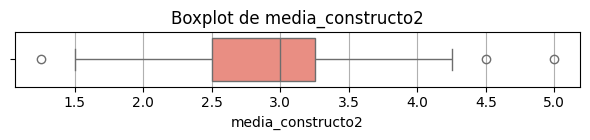

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 Variables a analizar
variables = ['Idade', 'media_constructo1', 'media_constructo2']

# 🧪 Función para detectar y mostrar outliers severos
def detectar_outliers_severos(df, variable):
    serie = df[variable].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR

    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]

    print(f"\n📌 Variable: {variable}")
    print(f"- IQR: {IQR:.2f}")
    print(f"- Límites: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"- N outliers severos: {len(outliers)}")

    if len(outliers) > 0:
        print("🔍 Valores atípicos severos detectados:")
        display(outliers)
    else:
        print("✅ Sin outliers severos detectados.")

    # 📊 Gráfico boxplot
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=serie, color='salmon')
    plt.title(f"Boxplot de {variable}")
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# ▶️ Ejecutar para cada variable
for var in variables:
    detectar_outliers_severos(df, var)


# Análisis bivariable

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestIndPower, FTestAnovaPower
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 🔧 Renombrar columnas para evitar errores con espacios
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    'Nivel educativo': 'Nivel_educativo',
    'Área Sanitaria na que traballa': 'Area_sanitaria',
    'Ámbito de traballo': 'Ambito'
}, inplace=True)

# 📊 Lista donde se guardarán los resultados
comparaciones = []

def registrar(nombre_var, test, estad, pval, decision, potencia, interpretacion):
    comparaciones.append({
        "Variable categórica": nombre_var,
        "Test": test,
        "Estadístico": round(estad, 3),
        "p-valor": round(pval, 5),
        "Significativo (α=0.05)": decision,
        "Potencia estimada": potencia if isinstance(potencia, str) else round(potencia, 3),
        "Interpretación": interpretacion
    })

# ✅ T-TEST: Sexo
grupos = df['Sexo'].dropna().unique()
g1 = df[df['Sexo'] == grupos[0]]['media_constructo1'].dropna()
g2 = df[df['Sexo'] == grupos[1]]['media_constructo1'].dropna()
t_stat, t_p = stats.ttest_ind(g1, g2, equal_var=False)
effect_size = (g1.mean() - g2.mean()) / np.sqrt((g1.std()**2 + g2.std()**2)/2)
power = TTestIndPower().solve_power(effect_size=abs(effect_size), nobs1=len(g1), alpha=0.05, ratio=len(g2)/len(g1))
registrar("Sexo", "T-test", t_stat, t_p, "Sí" if t_p < 0.05 else "No", power,
          "Diferencias entre sexos en percepción general" if t_p < 0.05 else "No hay diferencias entre sexos")

# ✅ ANOVA: Nivel educativo
modelo_ne = ols("media_constructo1 ~ C(Nivel_educativo)", data=df).fit()
anova_ne = sm.stats.anova_lm(modelo_ne, typ=2)
f_ne = anova_ne['F'][0]
p_ne = anova_ne['PR(>F)'][0]
eta2_ne = anova_ne['sum_sq'][0] / anova_ne['sum_sq'].sum()
es_ne = np.sqrt(eta2_ne / (1 - eta2_ne))
power_ne = FTestAnovaPower().solve_power(effect_size=es_ne, k_groups=df['Nivel_educativo'].nunique(), nobs=df.shape[0], alpha=0.05)
registrar("Nivel educativo", "ANOVA", f_ne, p_ne, "Sí" if p_ne < 0.05 else "No", power_ne,
          "Diferencias según nivel educativo" if p_ne < 0.05 else "No hay diferencias entre niveles")

# ✅ ANOVA: Ámbito
modelo_amb = ols("media_constructo1 ~ C(Ambito)", data=df).fit()
anova_amb = sm.stats.anova_lm(modelo_amb, typ=2)
f_amb = anova_amb['F'][0]
p_amb = anova_amb['PR(>F)'][0]
eta2_amb = anova_amb['sum_sq'][0] / anova_amb['sum_sq'].sum()
es_amb = np.sqrt(eta2_amb / (1 - eta2_amb))
power_amb = FTestAnovaPower().solve_power(effect_size=es_amb, k_groups=df['Ambito'].nunique(), nobs=df.shape[0], alpha=0.05)
registrar("Ámbito", "ANOVA", f_amb, p_amb, "Sí" if p_amb < 0.05 else "No", power_amb,
          "Diferencias según ámbito de traballo" if p_amb < 0.05 else "No hay diferencias entre ámbitos")

# ✅ ANOVA o Kruskal: Área sanitaria
if df['Area_sanitaria'].value_counts().min() < 3:
    grupos_area = [g.dropna() for _, g in df.groupby('Area_sanitaria')['media_constructo1']]
    h_stat, p_kw = stats.kruskal(*grupos_area)
    registrar("Área sanitaria", "Kruskal-Wallis", h_stat, p_kw, "Sí" if p_kw < 0.05 else "No", "—",
              "Diferencias entre áreas sanitarias" if p_kw < 0.05 else "No hay diferencias entre áreas")
else:
    modelo_area = ols("media_constructo1 ~ C(Area_sanitaria)", data=df).fit()
    anova_area = sm.stats.anova_lm(modelo_area, typ=2)
    f_area = anova_area['F'][0]
    p_area = anova_area['PR(>F)'][0]
    eta2_area = anova_area['sum_sq'][0] / anova_area['sum_sq'].sum()
    es_area = np.sqrt(eta2_area / (1 - eta2_area))
    power_area = FTestAnovaPower().solve_power(effect_size=es_area, k_groups=df['Area_sanitaria'].nunique(), nobs=df.shape[0], alpha=0.05)
    registrar("Área sanitaria", "ANOVA", f_area, p_area, "Sí" if p_area < 0.05 else "No", power_area,
              "Diferencias según área sanitaria" if p_area < 0.05 else "No hay diferencias entre áreas")

# 📋 Mostrar tabla resumen
tabla_resultados = pd.DataFrame(comparaciones)
from IPython.display import display
display(tabla_resultados)


<ipython-input-25-2205876642>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_ne = anova_ne['F'][0]
<ipython-input-25-2205876642>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_ne = anova_ne['PR(>F)'][0]
<ipython-input-25-2205876642>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta2_ne = anova_ne['sum_sq'][0] / anova_ne['sum_sq'].sum()
<ipython-input-25-2205876642>:54: FutureWarning: Series.__getitem__ treating keys as

,Variable categórica,Test,Estadístico,p-valor,Significativo (α=0.05),Potencia estimada,Interpretación
0,Sexo,T-test,2.029,0.05216,No,0.482,No hay diferencias entre sexos
1,Nivel educativo,ANOVA,1.179,0.31175,No,0.26,No hay diferencias entre niveles
2,Ámbito,ANOVA,3.277,0.07324,No,0.441,No hay diferencias entre ámbitos
3,Área sanitaria,Kruskal-Wallis,12.544,0.05088,No,—,No hay diferencias entre áreas


In [26]:
import pandas as pd
import numpy as np
from scipy import stats

# 🔧 Limpiar y renombrar columnas
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    'Nivel educativo': 'Nivel_educativo',
    'Ámbito de traballo': 'Ambito'
}, inplace=True)

# 📊 Lista para recoger los resultados
resultados_constructo2 = []

def registrar(var, test, estad, pval, decision, interpretacion):
    resultados_constructo2.append({
        "Variable categórica": var,
        "Test": test,
        "Estadístico": round(estad, 3),
        "p-valor": round(pval, 5),
        "Significativo (α=0.05)": decision,
        "Interpretación": interpretacion
    })

# 1️⃣ Mann–Whitney U para Sexo
if df['Sexo'].nunique() == 2:
    g1 = df[df['Sexo'] == df['Sexo'].unique()[0]]['media_constructo2'].dropna()
    g2 = df[df['Sexo'] == df['Sexo'].unique()[1]]['media_constructo2'].dropna()
    u_stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    registrar("Sexo", "Mann–Whitney U", u_stat, p,
              "Sí" if p < 0.05 else "No",
              "Diferencias entre sexos en constructo 2" if p < 0.05 else "No hay diferencias entre sexos")

# 2️⃣ Kruskal–Wallis para Nivel educativo
if df['Nivel_educativo'].nunique() > 2:
    grupos = [g.dropna() for _, g in df.groupby('Nivel_educativo')['media_constructo2']]
    h_stat, p = stats.kruskal(*grupos)
    registrar("Nivel educativo", "Kruskal–Wallis", h_stat, p,
              "Sí" if p < 0.05 else "No",
              "Diferencias entre niveles educativos" if p < 0.05 else "No hay diferencias entre niveles")

# 3️⃣ Kruskal–Wallis para Ámbito
if df['Ambito'].nunique() > 2:
    grupos = [g.dropna() for _, g in df.groupby('Ambito')['media_constructo2']]
    h_stat, p = stats.kruskal(*grupos)
    registrar("Ámbito", "Kruskal–Wallis", h_stat, p,
              "Sí" if p < 0.05 else "No",
              "Diferencias entre ámbitos" if p < 0.05 else "No hay diferencias entre ámbitos")

# 📋 Mostrar resultados en tabla
tabla_np = pd.DataFrame(resultados_constructo2)
from IPython.display import display
display(tabla_np)


,Variable categórica,Test,Estadístico,p-valor,Significativo (α=0.05),Interpretación
0,Sexo,Mann–Whitney U,1052.000,0.00877,Sí,Diferencias entre sexos en constructo 2
1,Nivel educativo,Kruskal–Wallis,1.212,0.54564,No,No hay diferencias entre niveles


In [27]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# 🧪 Relación Edad vs Constructo 1
edad1 = df['Idade'].dropna()
constr1 = df['media_constructo1'].dropna()
datos1 = df[['Idade', 'media_constructo1']].dropna()
rho1, pval1 = spearmanr(datos1['Idade'], datos1['media_constructo1'])

print("🔹 Relación Edad - Constructo 1")
print(f"Coeficiente de Spearman: {rho1:.3f}")
print(f"p-valor: {pval1:.5f}")
if pval1 < 0.05:
    print("✅ Relación estadísticamente significativa.")
else:
    print("❌ No hay relación significativa.")

# 🧪 Relación Edad vs Constructo 2
datos2 = df[['Idade', 'media_constructo2']].dropna()
rho2, pval2 = spearmanr(datos2['Idade'], datos2['media_constructo2'])

print("\n🔹 Relación Edad - Constructo 2")
print(f"Coeficiente de Spearman: {rho2:.3f}")
print(f"p-valor: {pval2:.5f}")
if pval2 < 0.05:
    print("✅ Relación estadísticamente significativa.")
else:
    print("❌ No hay relación significativa.")

# 📈 Gráfica de dispersión opcional (activar si lo deseas)
# sns.lmplot(data=datos1, x="Idade", y="media_constructo1", lowess=True, line_kws={'color': 'red'})
# plt.title("Relación entre Idade e Constructo 1")
# plt.show()

# sns.lmplot(data=datos2, x="Idade", y="media_constructo2", lowess=True, line_kws={'color': 'red'})
# plt.title("Relación entre Idade e Constructo 2")
# plt.show()


🔹 Relación Edad - Constructo 1
Coeficiente de Spearman: -0.120
p-valor: 0.23243
❌ No hay relación significativa.

🔹 Relación Edad - Constructo 2
Coeficiente de Spearman: -0.045
p-valor: 0.65315
❌ No hay relación significativa.


In [28]:
import numpy as np
from scipy.stats import norm

# ----------------------------
# PARÁMETROS DEL ESTUDIO
# ----------------------------

N = 940           # Tamaño de la población
n_real = 102      # Tamaño de la muestra real
sigma = 1.0       # Desviación estándar esperada (puedes cambiarla por la real si la conoces)
z = norm.ppf(0.975)  # Z para intervalo de confianza del 95% (dos colas)
precision_deseada = 0.1  # Precisión que querías alcanzar (±0.1)

# ----------------------------
# CÁLCULO DE LA PRECISIÓN ALCANZADA CON n = 102
# ----------------------------

# Error estándar corregido por población finita
se_real = sigma / np.sqrt(n_real) * np.sqrt((N - n_real) / (N - 1))
margen_error_alcanzado = z * se_real

print(f"📏 Precisión alcanzada con n = {n_real}: ±{round(margen_error_alcanzado, 3)} (95% CI)")

# ----------------------------
# CÁLCULO DEL TAMAÑO MUESTRAL NECESARIO PARA UNA PRECISIÓN DESEADA
# ----------------------------

# n sin corrección por población finita
n_necesario_sin_fpc = (z * sigma / precision_deseada)**2

# Ajuste por población finita
n_ajustado = n_necesario_sin_fpc / (1 + (n_necesario_sin_fpc - 1) / N)

print(f"🎯 Tamaño muestral necesario para precisión ±{precision_deseada}: {round(n_ajustado)} (ajustado por población finita)")


📏 Precisión alcanzada con n = 102: ±0.183 (95% CI)
🎯 Tamaño muestral necesario para precisión ±0.1: 273 (ajustado por población finita)


# Análisis multivariable

In [29]:
# Agrupación alternativa en tres grupos clínicos
df['grupo_idade_3cat'] = pd.cut(
    df['Idade'],
    bins=[0, 35, 50, df['Idade'].dropna().max()],
    labels=['≤ 35 anos', '36–50 anos', '> 50 anos'],
    right=True,
    include_lowest=True
)

# Ver distribución
print("Distribución por grupo de idade (3 categorías):")
print(df['grupo_idade_3cat'].value_counts().sort_index())


Distribución por grupo de idade (3 categorías):
grupo_idade_3cat
≤ 35 anos     42
36–50 anos    32
> 50 anos     27
Name: count, dtype: int64


In [32]:
print(df.columns.tolist())


['Marca temporal', 'Despois de ler a información sobre o estudo, acepta participar de forma voluntaria?', 'Idade', 'Sexo', 'Anos de experiencia profesional en enfermaría', 'Nivel_educativo', 'Area_sanitaria', 'Ambito', 'Con que frecuencia usa tecnoloxía dixital na súa práctica clínica fora dos programas corporativos?   "A tecnoloxía dixital inclúe calquera ferramenta electrónica ou software que empregue na súa práctica clínica, como historias clínicas electrónicas, aplicacións de xestión de pacientes, plataformas de teleconsulta, sistemas de prescrición electrónica, dispositivos de monitorización dixital ou ferramentas de apoio á toma de decisións clínicas baseadas en datos".', 'En que medida comprende o concepto de Intelixencia Artificial (IA)?', 'Usa IA no seu traballo para planificar ou realizar coidados?', 'Recibiu formación en IA ou educación previa sobre este tema?', 'Gustaríalle recibir formación sobre IA en saúde?', 'Que importancia lle dá á formación en intelixencia artificial

In [33]:
print('media_constructo1' in df.columns)  # Esto debe imprimir: True


True


📊 ANOVA - Constructo 1 (media_constructo1)
             Source         SS  DF        MS         F     p-unc      np2
0  grupo_idade_3cat   2.039397   2  1.019699  1.889022  0.156685  0.03712
1            Within  52.900647  98  0.539803       NaN       NaN      NaN

🎯 Potencia estimada: 0.395


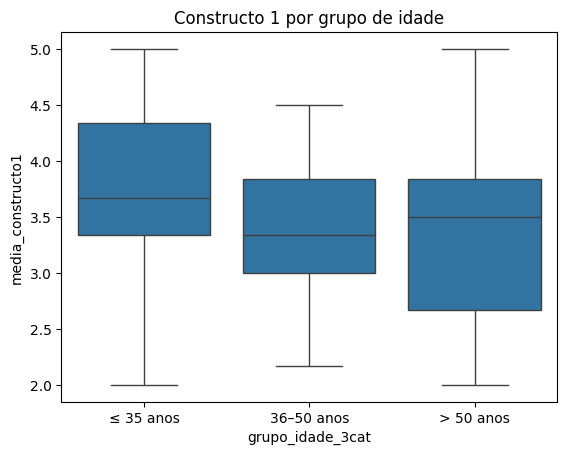


📊 Kruskal–Wallis - Constructo 2 (media_constructo2): H = 0.784, p = 0.67579


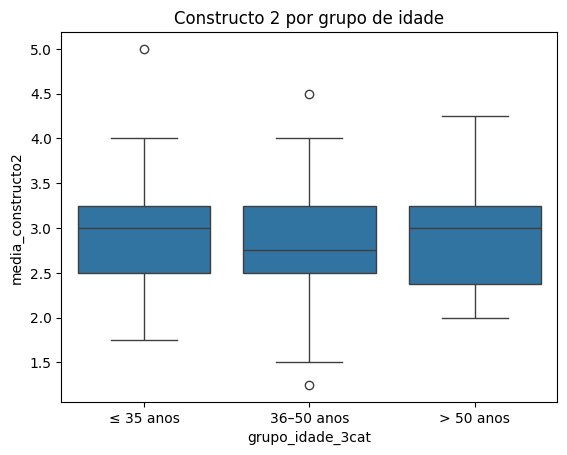

In [35]:
# ANÁLISIS CONSTRUCTO 1 (media_constructo1 - normal) → ANOVA
from statsmodels.stats.power import FTestAnovaPower
import pingouin as pg
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 1. ANOVA para media_constructo1
anova = pg.anova(dv='media_constructo1', between='grupo_idade_3cat', data=df, detailed=True)
print("📊 ANOVA - Constructo 1 (media_constructo1)")
print(anova)

# 2. Potencia estadística
eta2 = anova['np2'][0]
f2 = eta2 / (1 - eta2)
n = df.dropna(subset=['media_constructo1', 'grupo_idade_3cat']).shape[0]
k = df['grupo_idade_3cat'].nunique()
power = FTestAnovaPower().solve_power(effect_size=np.sqrt(f2), nobs=n, k_groups=k, alpha=0.05)
print(f"\n🎯 Potencia estimada: {round(power, 3)}")

# 3. Post-hoc Tukey si p < 0.05
if anova['p-unc'][0] < 0.05:
    print("\n🔍 Post-hoc Tukey:")
    tukey = pg.pairwise_tukey(dv='media_constructo1', between='grupo_idade_3cat', data=df)
    print(tukey)

# 4. Boxplot
sns.boxplot(data=df, x='grupo_idade_3cat', y='media_constructo1')
plt.title('Constructo 1 por grupo de idade')
plt.ylabel("media_constructo1")
plt.show()

# --------------------------

# 5. Kruskal–Wallis para media_constructo2 (no normal)
grupos = df['grupo_idade_3cat'].dropna().unique()
valores = [df[df['grupo_idade_3cat'] == g]['media_constructo2'].dropna() for g in grupos]
kruskal = stats.kruskal(*valores)
print(f"\n📊 Kruskal–Wallis - Constructo 2 (media_constructo2): H = {kruskal.statistic:.3f}, p = {kruskal.pvalue:.5f}")

# 6. Post-hoc Dunn si p < 0.05
if kruskal.pvalue < 0.05:
    print("\n🔍 Post-hoc Dunn (con Bonferroni):")
    dunn = sp.posthoc_dunn(df, val_col='media_constructo2', group_col='grupo_idade_3cat', p_adjust='bonferroni')
    print(dunn)

# 7. Boxplot
sns.boxplot(data=df, x='grupo_idade_3cat', y='media_constructo2')
plt.title('Constructo 2 por grupo de idade')
plt.ylabel("media_constructo2")
plt.show()


In [37]:
print(df.columns.tolist())


['Marca temporal', 'Despois de ler a información sobre o estudo, acepta participar de forma voluntaria?', 'Idade', 'Sexo', 'Anos de experiencia profesional en enfermaría', 'Nivel_educativo', 'Area_sanitaria', 'Ambito', 'Con que frecuencia usa tecnoloxía dixital na súa práctica clínica fora dos programas corporativos?   "A tecnoloxía dixital inclúe calquera ferramenta electrónica ou software que empregue na súa práctica clínica, como historias clínicas electrónicas, aplicacións de xestión de pacientes, plataformas de teleconsulta, sistemas de prescrición electrónica, dispositivos de monitorización dixital ou ferramentas de apoio á toma de decisións clínicas baseadas en datos".', 'En que medida comprende o concepto de Intelixencia Artificial (IA)?', 'Usa IA no seu traballo para planificar ou realizar coidados?', 'Recibiu formación en IA ou educación previa sobre este tema?', 'Gustaríalle recibir formación sobre IA en saúde?', 'Que importancia lle dá á formación en intelixencia artificial

In [38]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

# Reemplaza esto con tu dataframe real si no lo tienes cargado aún
# df = pd.read_csv('ruta/del/archivo.csv')

# Renombrar para mayor claridad
df = df.rename(columns={
    'Recibiu formación en IA ou educación previa sobre este tema?': 'formacion_IA',
    'Usa IA no seu traballo para planificar ou realizar coidados?': 'uso_IA'
})

# Crear tabla de contingencia
tabla = pd.crosstab(df['formacion_IA'], df['uso_IA'])
print("🔢 Tabla de contingencia:\n", tabla)

# Evaluar si aplicar Fisher o Chi-cuadrado
if tabla.shape == (2, 2) and (tabla.values < 5).sum() > 0:
    print("\n🧪 Aplicando test exacto de Fisher (2x2 con celdas pequeñas):")
    _, p_fisher = fisher_exact(tabla)
    print(f"📌 p-valor (Fisher): {p_fisher:.4f}")
else:
    print("\n🧪 Aplicando test Chi-cuadrado:")
    chi2, p_chi, dof, expected = chi2_contingency(tabla)
    print(f"📌 Chi-cuadrado: {chi2:.4f}")
    print(f"📌 p-valor: {p_chi:.4f}")
    print(f"📌 Grados de libertad: {dof}")
    print("📌 Frecuencias esperadas:\n", pd.DataFrame(expected, index=tabla.index, columns=tabla.columns))


🔢 Tabla de contingencia:
 uso_IA                                              Non  Non sei  Sí
formacion_IA                                                        
Cursos autodidactas (webinars, conferencias, etc.)   15        1   7
Formación no traballo                                 2        2   4
Ningunha                                             43       19   9

🧪 Aplicando test Chi-cuadrado:
📌 Chi-cuadrado: 12.7292
📌 p-valor: 0.0127
📌 Grados de libertad: 4
📌 Frecuencias esperadas:
 uso_IA                                                    Non    Non sei  \
formacion_IA                                                               
Cursos autodidactas (webinars, conferencias, etc.)  13.529412   4.960784   
Formación no traballo                                4.705882   1.725490   
Ningunha                                            41.764706  15.313725   

uso_IA                                                     Sí  
formacion_IA                                                

In [45]:
# LIBRERÍAS
import pandas as pd
from scipy.stats import ttest_ind, f_oneway
import warnings
warnings.filterwarnings("ignore")

# CARGA DE DATOS
df = pd.read_csv("Estudio UNIR.csv")

# RENOMBRADO Y LIMPIEZA DE VARIABLES CLAVE
df = df.rename(columns={
    'Recibiu formación en IA ou educación previa sobre este tema?  ': 'formacion_IA',
    'Usa IA no seu traballo para planificar ou realizar coidados?  ': 'uso_IA',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?  ': 'entiende_IA',
    'Gustaríalle recibir formación sobre IA en saúde?  ': 'desea_formacion',
    'Sexo': 'sexo',
    'Idade  ': 'idade',
    ' Nivel educativo  ': 'nivel_educativo',
    ' Anos de experiencia profesional en enfermaría  ': 'anos_exp',
    '  Área Sanitaria na que traballa  ': 'area_sanitaria',
    'Ámbito de traballo': 'ambito'
})

# VARIABLES EXPLICATIVAS CUALITATIVAS
variables_cat = ['sexo', 'formacion_IA', 'uso_IA', 'entiende_IA', 'desea_formacion', 'grupo_idade_3cat', 'nivel_educativo', 'anos_exp', 'area_sanitaria', 'ambito']
dimensiones = ['media_constructo1', 'media_constructo2']

# LIMPIEZA DE TEXTO
for var in variables_cat:
    if var in df.columns:
        df[var] = df[var].astype(str).apply(lambda x: x.strip().replace('\n', ' ').replace('\r', ' '))

# ANÁLISIS
resultados = []

for dimension in dimensiones:
    for var in variables_cat:
        grupos = df[var].dropna().unique()
        if len(grupos) == 2:
            g1 = df[df[var] == grupos[0]][dimension].dropna()
            g2 = df[df[var] == grupos[1]][dimension].dropna()
            stat, p = ttest_ind(g1, g2, equal_var=False)
            prueba = "t de Student"
        elif len(grupos) > 2:
            data_grupos = [df[df[var] == g][dimension].dropna() for g in grupos]
            stat, p = f_oneway(*data_grupos)
            prueba = "ANOVA"
        else:
            continue  # Solo un grupo, no se compara

        resultados.append({
            "Dimensión": dimension,
            "Variable": var,
            "Prueba": prueba,
            "p-valor": round(p, 4),
            "Significativo": "Sí" if p < 0.05 else "No"
        })

# RESULTADOS EN DATAFRAME
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="p-valor")

# MOSTRAR RESULTADOS
df_resultados


KeyError: 'media_constructo1'

In [44]:
# 📦 1. Importar librerías necesarias
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway
from sklearn.preprocessing import LabelEncoder
from factor_analyzer import FactorAnalyzer
import pingouin as pg  # para alfa de Cronbach

# 📥 2. Cargar el dataset
df = pd.read_csv('/content/Estudio UNIR.csv')

# ✅ 3. Renombrar las variables clave (ajustado a tu dataset)
df = df.rename(columns={
    'Recibiu formación en IA ou educación previa sobre este tema?': 'formacion_IA',
    'Usa IA no seu traballo para planificar ou realizar coidados?': 'uso_IA',
    'Gustaríalle recibir formación sobre IA en saúde?': 'desea_formacion',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?': 'entiende_IA',
    'grupo_idade_3cat': 'grupo_idade'
})

# ✅ 4. Construir las dos dimensiones del SHAIP
constructo1_items = [
    '1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.',
    '2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas',
    '3.Creo que a IA pode mellorar os indicadores de saúde da poboación',
    '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro',
    '5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo',
    '6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario'
]

constructo2_items = [
    '7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA',
    '8.Creo que recibín unha formación adecuada para usar IA no meu traballo',
    '9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo',
    '10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario'
]

# Convertir a numérico (por si acaso)
df[constructo1_items + constructo2_items] = df[constructo1_items + constructo2_items].apply(pd.to_numeric, errors='coerce')

# Calcular medias
df['impacto_profesional'] = df[constructo1_items].mean(axis=1)
df['preparacion_IA'] = df[constructo2_items].mean(axis=1)

# ✅ 5. Alfa de Cronbach (usando pingouin)
print("\n🔹 Alfa de Cronbach - Impacto profesional:")
print(pg.cronbach_alpha(data=df[constructo1_items]))

print("\n🔹 Alfa de Cronbach - Preparación para IA:")
print(pg.cronbach_alpha(data=df[constructo2_items]))

# ✅ 6. Análisis factorial exploratorio (EFA básico)
fa_df = df[constructo1_items + constructo2_items].dropna()
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(fa_df)

print("\n🔸 Cargas factoriales:")
print(pd.DataFrame(fa.loadings_, index=fa_df.columns))

# ✅ 7. Comparaciones bivariantes (ANOVA o t-test)

def comparar_dimensiones(var_exp, dimension):
    grupos = df[var_exp].dropna().unique()
    grupos_data = [df[df[var_exp] == g][dimension].dropna() for g in grupos]

    if len(grupos) == 2:
        stat, p = ttest_ind(*grupos_data)
        test = "t de Student"
    else:
        stat, p = f_oneway(*grupos_data)
        test = "ANOVA"

    print(f"\n🔹 {dimension} según {var_exp} ({test}):")
    print(f"Estadístico = {stat:.4f}, p = {p:.4f}")
    return p

# 🔍 Aplicar a variables clave
variables_explicativas = ['Sexo', 'grupo_idade', 'formacion_IA', 'uso_IA', 'desea_formacion', 'entiende_IA']

for var in variables_explicativas:
    comparar_dimensiones(var, 'impacto_profesional')
    comparar_dimensiones(var, 'preparacion_IA')


KeyError: "None of [Index(['1.Creo que o uso da IA na miña especialidade podería mellorar a atención aos pacientes.',\n       '2. Creo que o uso da IA na miña especialidade podería mellorar a toma de decisións clínicas',\n       '3.Creo que a IA pode mellorar os indicadores de saúde da poboación',\n       '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro',\n       '5.Creo que a introdución da IA pode reducir o custo económico asociado ao meu traballo',\n       '6.Creo que algún día a IA poderá formar parte do meu traballo como profesional sanitario',\n       '7.Creo que a maioría dos profesionais sanitarios están preparados para a introdución da tecnoloxía baseada en IA',\n       '8.Creo que recibín unha formación adecuada para usar IA no meu traballo',\n       '9.Creo que existe un marco ético para o uso da tecnoloxía baseada en IA no meu lugar de traballo',\n       '10.Creo que, se a tecnoloxía baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario'],\n      dtype='object')] are in the [columns]"